# Exploring Echoregions Lines Functionality

Prior to running this notebook and all other notebooks, make sure you have installed the packages found in `requirements.txt`.

This notebook parses bottom values from an Echoview `.evl` file and masks them over corresponding sonar data.

In [55]:
# Importing Packages
import matplotlib.pyplot as plt
import os
import urllib.request
import shutil
import xarray as xr
import numpy as np

import echoregions as er

### Bottom Data Reading

In [33]:
# Set path to test data
TEST_DATA_PATH = 'https://raw.githubusercontent.com/OSOceanAcoustics/echoregions/update_notebook_docs/echoregions/test_data'

# Download example EVL File
urllib.request.urlretrieve(f"{TEST_DATA_PATH}/transect.evl","transect.evl")

# Read EVL file
lines = er.read_evl('transect.evl')

#### Lines as a DataFrame

`lines` is a specialized object but it has a `data` attribute which is a simple dataframe.

In [17]:
# Store the object's data in a dataframe
lines_df = lines.data

In [18]:
lines_df

,file_name,file_type,evl_file_format_version,echoview_version,time,depth,status
0,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 18:39:41.321000,442.996834,3
1,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 18:39:42.679000,437.818405,3
2,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 18:39:44.031000,445.194735,1
3,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 18:39:45.380000,451.168987,3
4,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 18:39:46.728000,442.551006,3
...,...,...,...,...,...,...,...
3166,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 21:04:47.146000,760.707803,3
3167,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 21:04:47.147000,762.196532,3
3168,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 21:10:40.095000,766.613696,3
3169,transect.evl,EVBD,3,13.0.378.44817,2019-07-02 21:10:40.096000,763.976879,3


Note the rightmost column status. Status values are generally described by the following:

0 = none
1 = unverified
2 = bad
3 = good

The good and bad values are assigned via the specific EVL line picking formula used to generate the initial EVL file. Generally, we only want the rows with good/3 status.

More information on Echoview Status can be found here: https://support.echoview.com/WebHelp/Using_Echoview/Echogram/Lines/About_Line_Status.htm.

Let's now plot good points.

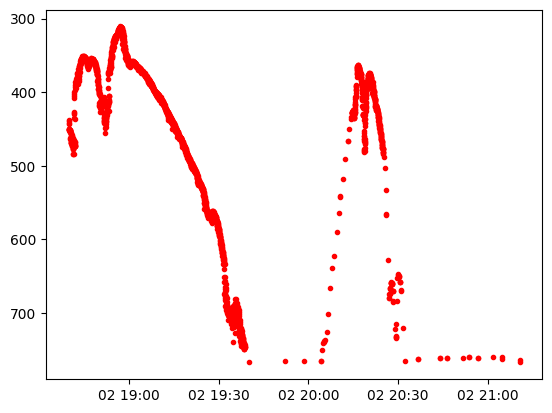

In [20]:
# Status 3 are good points so we select those
good_lines_df = lines_df[lines_df['status'] =='3']
good_bottom = good_lines_df[['time','depth']]
plt.plot(good_bottom['time'], good_bottom['depth'],'r.')
plt.gca().invert_yaxis()

For usage later on, let's put set this good dataframe as the current line dataframe

In [21]:
lines.data = good_lines_df

### Sonar Data Reading and Plotting

Let's now download and plot some Sonar backscatter data created using Echopype. Echopype is a sonar backscatter parsing and scientific computation software for which Echoregions (a sonar annotation parsing software) is built to be used in conjunction with.

More information regarding Echopype can be found here: https://echopype.readthedocs.io/en/stable/.

In [41]:
# Download example Echopype Sonar Zarr File
urllib.request.urlretrieve(f"{TEST_DATA_PATH}/transect.zip","transect.zip")

# Extract the ZIP file
shutil.unpack_archive("transect.zip", "")

# Read EVL file
ds_Sv = xr.open_dataset('transect.zarr', engine="zarr")

In [45]:
ds_Sv["Sv"]

<xarray.DataArray 'Sv' (depth: 3955, ping_time: 1681, channel: 3)>
[19945065 values with dtype=float64]
Coordinates:
  * channel       (channel) <U37 'GPT  18 kHz 009072058c8d 1-1 ES18-11' ... '...
  * depth         (depth) float64 9.15 9.34 9.529 9.719 ... 758.1 758.3 758.5
  * ping_time     (ping_time) datetime64[ns] 2019-07-02T18:40:00 ... 2019-07-...
    range_sample  (depth) int64 ...
Attributes:
    actual_range:  [-156.0, 37.68]
    long_name:     Volume backscattering strength (Sv re 1 m-1)
    units:         dB

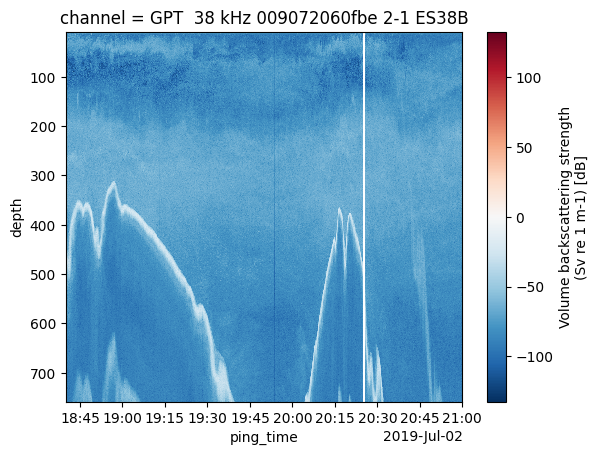

In [44]:
# Plot the 38 kHz backscatter channel
ds_Sv["Sv"].isel(channel=1).plot(y="depth", yincrease=False)

### Plotting and Masking Sonar and Bottom

From the two previous plots, one can kind of see how they're related on both the depth and time dimensions. Now let's see bottom annotations overlayed on top of the Sonar dataset.

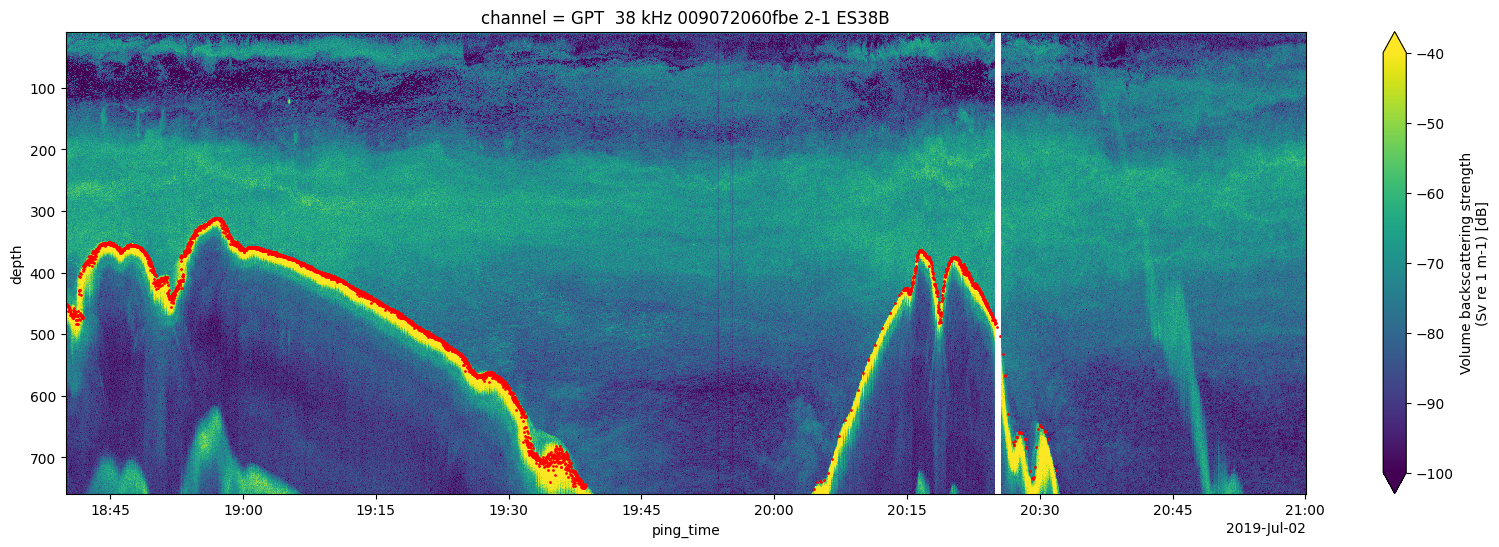

In [48]:
# Plotting the sonar data and the bottom
plt.figure(figsize = (20, 6))
ds_Sv.Sv.isel(channel=1).T.plot(y="depth", yincrease=False, vmax=-40, vmin=-100)
plt.plot(lines.data['time'], lines.data['depth'],'ro',fillstyle='full', markersize=1)

We can see that there is clear overlap between the two pieces of data here. However, for machine learning training purposes, and more specifically, for computer vision segmentation model training, point data is not enough and so we require masks of the sonar data.

Lines class has a function to do this specific task. There are a few different Pandas interpolation schemes one can pass in, but for this example we stick with something simple "slinear" which refers to a first order spline.

In [52]:
# Use the built in mask function
bottom_mask_da, bottom_contours = lines.mask(
    ds_Sv["Sv"].isel(channel=1).drop_vars("channel").compute(),
    method="slinear",
    limit_area=None,
    limit_direction="both"
)

The output should be both the interpolated points that constitute the bottom mask and the bottom mask itself.

Let's take a look at the mask `bottom_mask_da` first:

As a sanity check, let us check that the `ping_time` and `depth` dimensions in the bottom mask `bottom_mask_da` are equal to that in the backscatter sonar data `ds_Sv["Sv]`:

In [63]:
print(
    "Bottom Mask Ping Time Dimension Length:",
    len(bottom_mask_da["ping_time"])
)
print(
    "Bottom Mask Depth Dimension Length:",
    len(bottom_mask_da["depth"])
)
print(
    "Backscatter Sonar Ping Time Dimension Length:",
    len(ds_Sv["Sv"]["ping_time"])
)
print(
    "Backscatter Sonar Depth Dimension Length:",
    len(ds_Sv["Sv"]["depth"])
)

Bottom Mask Ping Time Dimension Length: 1681
Bottom Mask Depth Dimension Length: 3955
Backscatter Sonar Ping Time Dimension Length: 1681
Backscatter Sonar Depth Dimension Length: 3955


The values in the bottom mask should also just be 1s and 0s

In [65]:
print("Unique Values in Bottom Mask:", np.unique(bottom_mask_da.data))

Unique Values in Bottom Mask: [0 1]


A plot of the mask itself:

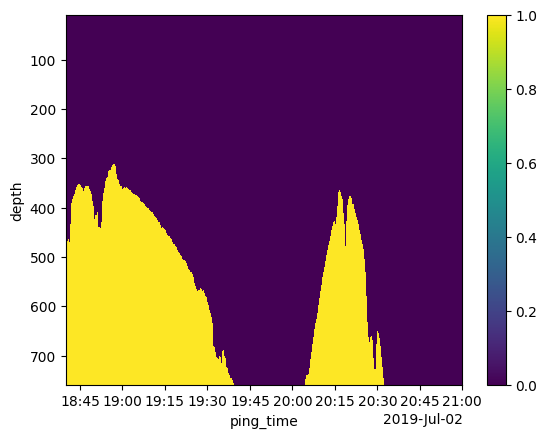

In [54]:
bottom_mask_da.plot(y="depth", yincrease=False)

In [ ]:
A plot of the 38 kHz channel where the mask exists:

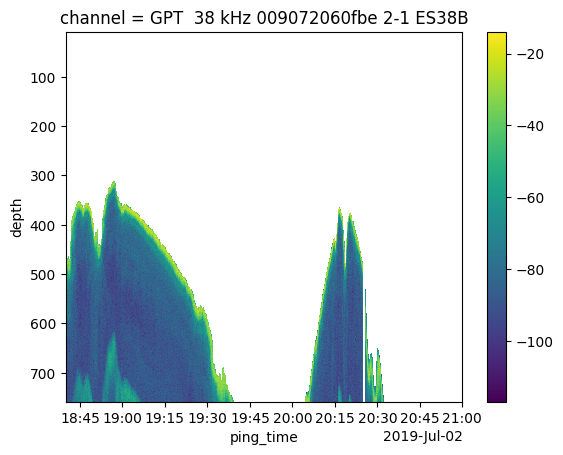

In [66]:
# Get only 38 kHz channel values where the mask is 1
mask_exists_Sv = xr.where(
    bottom_mask_da == 1,
    ds_Sv["Sv"].isel(channel=1),
    np.nan,
)

# Plot the masked Sv
mask_exists_Sv.plot(y = "depth", yincrease = False)

Let's now take a look at the interpolated points `bottom_contours`:

Let's compare its number of rows to the number of rows from the lines dataframe it was created from.

In [72]:
print("Interpolated Rows:", len(bottom_contours))
print("Original Rows:", len(lines.data))

Interpolated Rows: 1681
Original Rows: 3171


This is strange, right?

Why are there more rows in the original rows than there are in the intepolated rows? It's because the interpolation function `splines` within `lines.mask` smooths out the data.

Let's now show this in a plot:

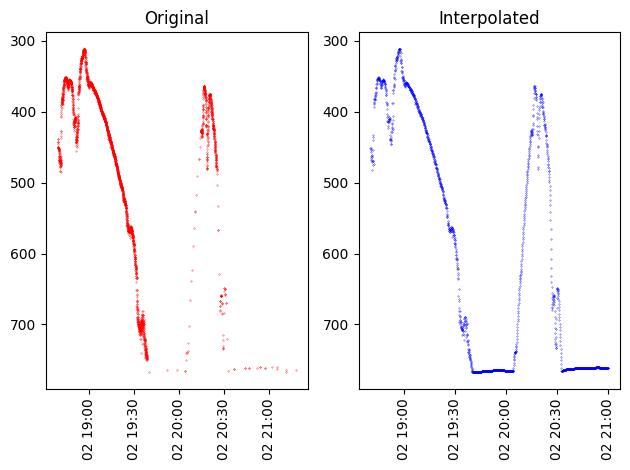

In [82]:
# Plot both original and interpolated
plt.subplot(1, 2, 1)
plt.plot(lines.data['time'], lines.data['depth'], 'r.', markersize=0.5)
plt.gca().invert_yaxis()
plt.title('Original')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.plot(bottom_contours['time'], bottom_contours['depth'], 'b.', markersize=0.5)
plt.gca().invert_yaxis()
plt.title('Interpolated')
plt.xticks(rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()